In [1]:
from pydicom import dcmread
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
import numpy as np
import os

In [2]:
def matrices_from_directory(dir="/Users/James/Desktop/MRI/PERFUSION_WEIGHTED_SPLIT_1_0103"):
    """
    Function takes DICOM files from directory and converts them to an animation object
    """

    matrices = []

    for file in os.listdir(dir):
        arr = dcmread(dir+"/"+file).pixel_array
        matrices.append(arr)
    return matrices

In [ ]:
arr = dcmread("../../data/EXP31_EXVIVO_01122021_D884+D885.MR.RESEARCH_GRONINGEN.0002.0001.2021.12.02.03.00.12.770900.531898856.IMA")
dir(arr)

### Lets add filtering

In [3]:
from fs.zipfs import ZipFS


with ZipFS("/Users/James/Downloads/T2_raw.zip") as myzip:
    print(myzip.listdir('T2_raw/Exp 10/Invivo/COR_T2_3MM_BELLOWS_STRAIGHT_0004'))

['EXP10_INVIVO_22062021_D842+D843.MR.RESEARCH_GRONINGEN.0004.0001.2021.06.23.21.55.33.991676.321483044.IMA', 'EXP10_INVIVO_22062021_D842+D843.MR.RESEARCH_GRONINGEN.0004.0002.2021.06.23.21.55.33.991676.321482856.IMA', 'EXP10_INVIVO_22062021_D842+D843.MR.RESEARCH_GRONINGEN.0004.0003.2021.06.23.21.55.33.991676.321483062.IMA', 'EXP10_INVIVO_22062021_D842+D843.MR.RESEARCH_GRONINGEN.0004.0004.2021.06.23.21.55.33.991676.321482882.IMA', 'EXP10_INVIVO_22062021_D842+D843.MR.RESEARCH_GRONINGEN.0004.0005.2021.06.23.21.55.33.991676.321483080.IMA', 'EXP10_INVIVO_22062021_D842+D843.MR.RESEARCH_GRONINGEN.0004.0006.2021.06.23.21.55.33.991676.321482900.IMA', 'EXP10_INVIVO_22062021_D842+D843.MR.RESEARCH_GRONINGEN.0004.0007.2021.06.23.21.55.33.991676.321483098.IMA', 'EXP10_INVIVO_22062021_D842+D843.MR.RESEARCH_GRONINGEN.0004.0008.2021.06.23.21.55.33.991676.321482918.IMA', 'EXP10_INVIVO_22062021_D842+D843.MR.RESEARCH_GRONINGEN.0004.0009.2021.06.23.21.55.33.991676.321483116.IMA', 'EXP10_INVIVO_22062021_D842

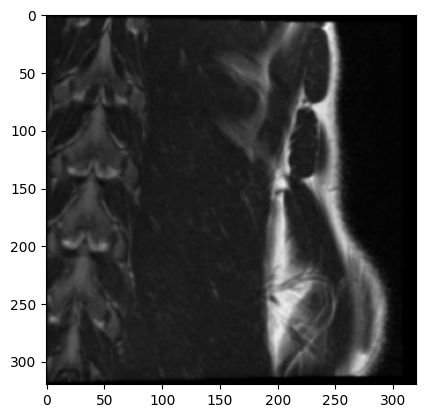

In [219]:
from scipy.ndimage import sobel, gaussian_filter, median_filter
from skimage.filters import frangi
import cv2
from pathlib import Path


def animation_from_directory(dir="/Users/James/Desktop/MRI/PERFUSION_WEIGHTED_SPLIT_1_0103"):
    """
    Function takes DICOM files from directory and converts them to an animation object
    """

    imgs = []
    fig, ax = plt.subplots()

    for file in os.listdir(dir):
        arr = dcmread(dir+"/"+file).pixel_array
        arr = gaussian_filter(arr, 1)
        im = ax.imshow(arr, animated = True, cmap="grey")
        imgs.append([im])

    ani = animation.ArtistAnimation(fig, imgs, interval=150, blit=True,
                                    repeat_delay=1000)
    return ani

ani = animation_from_directory(dir="/Users/James/Desktop/T2_raw/Exp 3/Invivo/COR_T2_3MM_BELLOWS_LEFT_PHASE_OVERSAMPLING_0003")
ani.save("../../animations/frangi_filtered.mp4")
ani

In [220]:
mtc = matrices_from_directory("/Users/James/Desktop/T2_raw/Exp 3/Invivo/COR_T2_3MM_BELLOWS_LEFT_PHASE_OVERSAMPLING_0003")

In [221]:
mt = mtc[9]
standardized = (mt - mt.mean()) / mt.std()

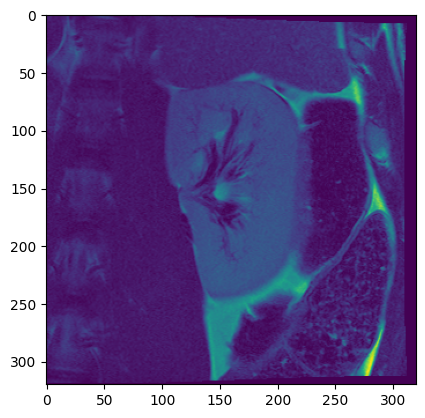

In [222]:
plt.imshow(standardized)
plt.show()

c:\Users\James\miniforge3\envs\mri\lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\James\miniforge3\envs\mri\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


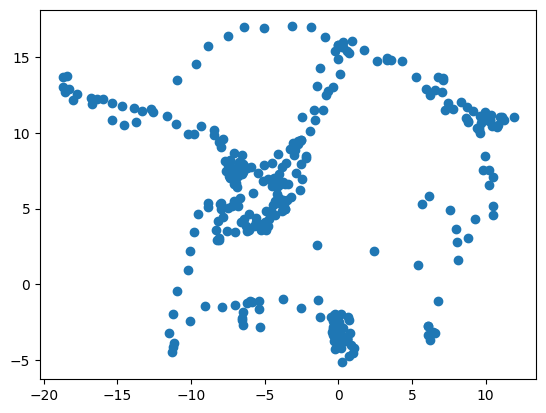

In [223]:
covmat = np.cov(standardized, rowvar=False)
eigvalues, eigvectors = np.linalg.eig(covmat)

# sort
order = np.argsort(eigvalues)[::-1]
sorted_eigvals = eigvalues[order]
sorted_eigvecs = eigvectors[:,order]
explained_variance = sorted_eigvals / np.sum(sorted_eigvecs)
k = 2
reduced_data = np.matmul(standardized, sorted_eigvecs[:,:k]) # transform the original data
reduced_data
plt.scatter(reduced_data[:,0], reduced_data[:,1])
plt.show()

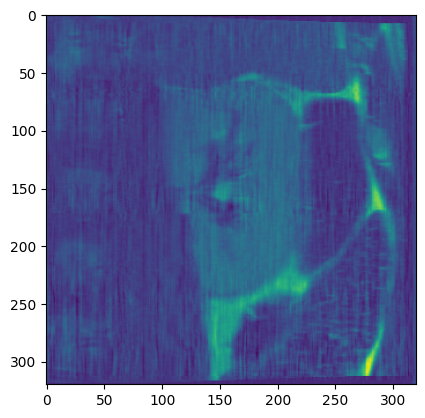

In [228]:
def compress_grayscale_pca(image, n_components):
    """
    Minimal implementation of PCA compression for grayscale images.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Grayscale image array with shape (height, width)
    n_components : int
        Number of principal components to keep
        
    Returns:
    --------
    compressed : numpy.ndarray
        Compressed grayscale image
    """
    # Center the data
    mean_val = np.mean(image)
    centered = image - mean_val
    
    # Compute covariance matrix
    cov = np.cov(centered)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx[:n_components]]
    
    # Project data onto principal components
    weights = np.dot(centered, eigenvectors)
    
    # Reconstruct
    compressed = np.dot(weights, eigenvectors.T) + mean_val
    
    return compressed

compressed = compress_grayscale_pca(mt, n_components=60)
plt.imshow(compressed)
plt.show()

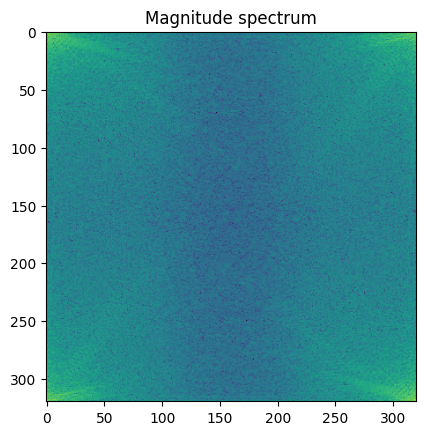

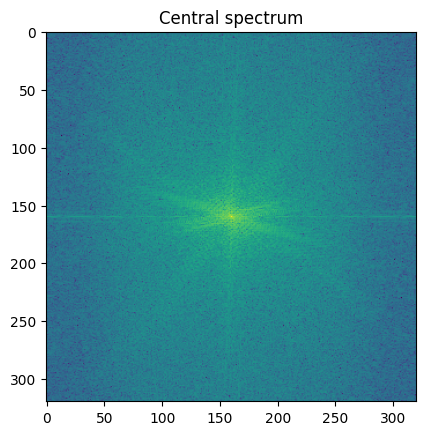

In [229]:
img = standardized

f = np.fft.fft2(np.abs(img))
mag = 20*np.log(np.abs(f))
plt.imshow(mag)
plt.title("Magnitude spectrum")
plt.show()

fshift = np.fft.fftshift(f)
smag = 20*np.log(np.abs(fshift))
plt.imshow(smag)
plt.title("Central spectrum")
plt.show()

In [230]:
def e_dist(p1, p2):
    return np.linalg.norm(p1 - p2)

p1 = np.array([1, 3])
p2 = np.array([4, 10])


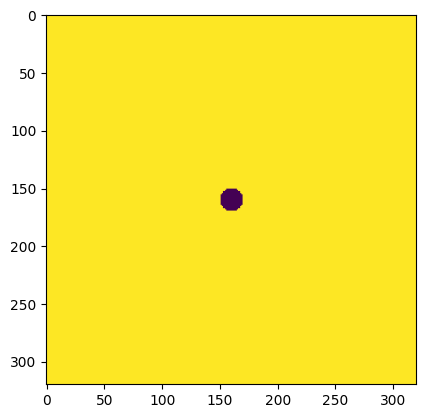

In [231]:
def create_circle_mask(img, diameter=10):
    base = np.zeros_like(img)
    ys, xs = img.shape
    center = np.array(img.shape)//2
    diameter = diameter

    for x in range(xs):
        for y in range(ys):
            point = np.array([x, y])
            if e_dist(point, center) >= diameter:
                base[y, x] = 1
    return base

base = create_circle_mask(img, 10)

plt.imshow(base)
plt.show()

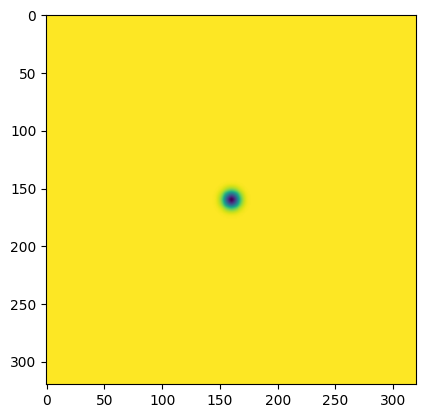

In [232]:
def create_gaussian_mask(img, std=1):
    base = np.zeros_like(img)
    mu = img.mean()
    ys, xs = img.shape
    center = np.array(img.shape)//2

    for x in range(xs):
        for y in range(ys):
            point = np.array([x, y])
            base[y, x] = ((np.exp(-((e_dist(point, center)-mu)**2)/
                                  (2*std**2)))/
                                  np.sqrt(2*mu*std**2+1e-6))
    return base    

mask = create_gaussian_mask(standardized, 5) * -1
plt.imshow(mask)
plt.show()

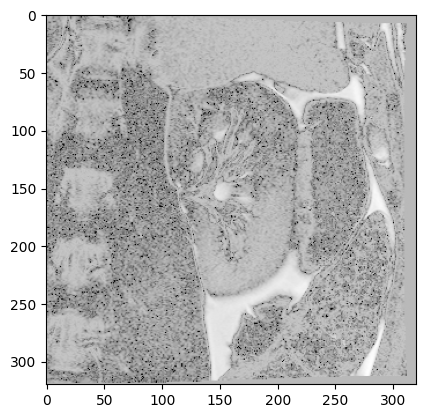

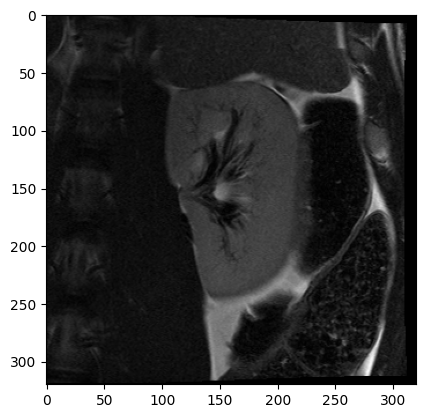

In [242]:
base = create_circle_mask(standardized, .05)
# mask = create_gaussian_mask(standardized, 120)

img = np.log(1e-6 + abs(
    np.fft.ifft2(
        np.fft.ifftshift(fshift * base))))

import cv2

# edges = cv2.Canny(img, 100, 200)

plt.imshow(img, cmap="grey")
plt.show()

plt.imshow(mt, cmap="grey")
plt.show()